In [3]:
import os
import glob
import sys
import common as com
import numpy
import tqdm
import sklearn
import torch
from train import list_to_vector_array
from train import file_list_generator
from train import AutoEncoder
from train import fetch_dataloaders
import torch.nn as nn

In [17]:
########################################################################
# visualizer
########################################################################
class Visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss):
        """
        Plot loss curve.
        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.
        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        #设置y轴范围
        #self.plt.ylim(-5,100)
        ax.set_title("batch loss")
        ax.set_xlabel("batch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Validation"], loc="upper right")

    def save_figure(self, name):
        """
        Save figure.
        name : str
            save png file path.
        return : None
        """
        self.plt.savefig(name)

########################################################################


In [36]:
param = com.yaml_load()
def test(dir,save):
    ab_files = file_list_generator(param["ab_dictionary"], dir_name=dir)
    com.logger.info('files num {num}'.format(num=len(ab_files)))
    ab_data = list_to_vector_array(ab_files,
                                      msg="generate train_dataset",
                                      n_mels=param["feature"]["n_mels"],
                                      frames=param["feature"]["frames"],
                                      n_fft=param["feature"]["n_fft"],
                                      hop_length=param["feature"]["hop_length"],
                                      power=param["feature"]["power"])
    ab_data = torch.Tensor(ab_data)
    com.logger.info('{dic}_data num {num}'.format(dic=dir,num=len(ab_data)))
    ab_loader = torch.utils.data.DataLoader(dataset=ab_data, batch_size=param["test_batch_size"], shuffle=True)
    model = torch.load(param["model_file"])
    loss_func = nn.MSELoss()
    features = []
    losses = []
    for data in ab_loader:
        inumpyuts = data
        feature, y = model(inumpyuts)
        loss = loss_func(y, inumpyuts)
        for one_feature in feature:
            features.append(list(one_feature))
        losses.append(loss.detach())
    #numpy.save('feature/'+save,numpy.array(features))
    return features,losses

feature,feature_loss = test('train','feature')
ab_feature,ab_loss = test('test/abnormal','abnormal_feature')
normal_feature,normal_loss = test('test/new_normal_one','normal_feature')


2021-10-21 22:56:55,733 - INFO - target_dir : ../file/noise_detecttrain
2021-10-21 22:56:55,879 - INFO - train_file num : 200
2021-10-21 22:56:55,880 - INFO - files num 200
generate train_dataset: 100%|██████████| 200/200 [00:06<00:00, 29.74it/s]
2021-10-21 22:57:03,501 - INFO - train_data num 115400
2021-10-21 22:58:12,156 - INFO - target_dir : ../file/noise_detecttest/abnormal
2021-10-21 22:58:12,157 - INFO - train_file num : 4
2021-10-21 22:58:12,158 - INFO - files num 4
generate train_dataset: 100%|██████████| 4/4 [00:00<00:00, 29.60it/s]
2021-10-21 22:58:12,308 - INFO - test/abnormal_data num 2308
2021-10-21 22:58:13,439 - INFO - target_dir : ../file/noise_detecttest/new_normal_one
2021-10-21 22:58:13,440 - INFO - train_file num : 20
2021-10-21 22:58:13,441 - INFO - files num 20
generate train_dataset: 100%|██████████| 20/20 [00:00<00:00, 37.14it/s]
2021-10-21 22:58:14,041 - INFO - test/new_normal_one_data num 11540


361


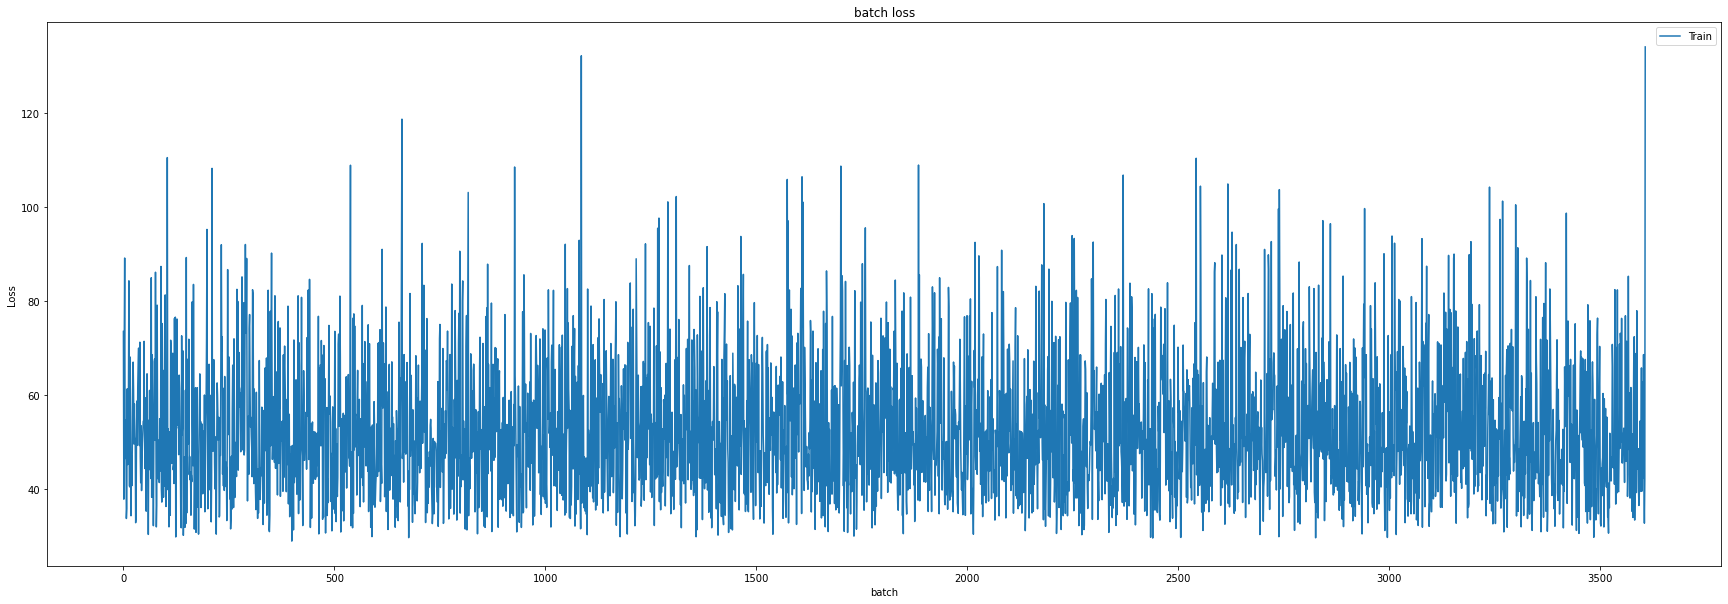

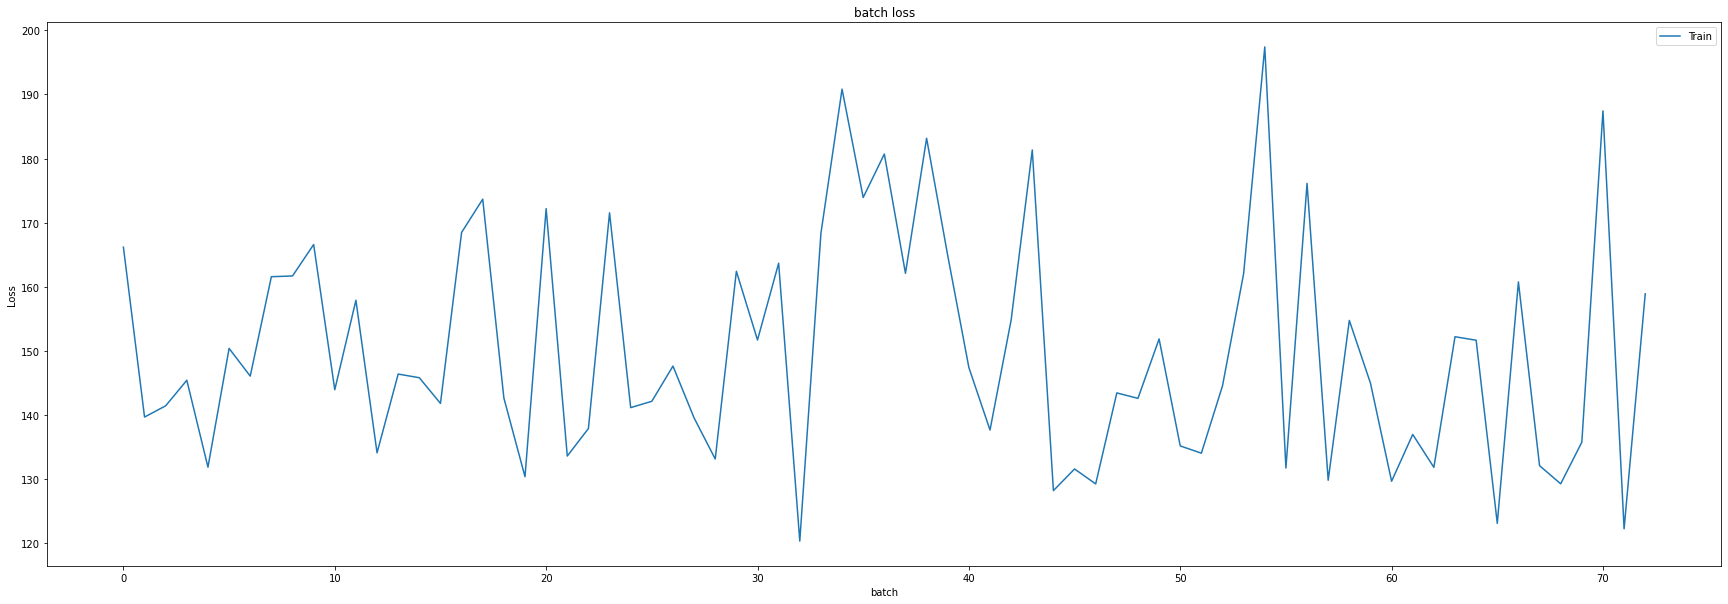

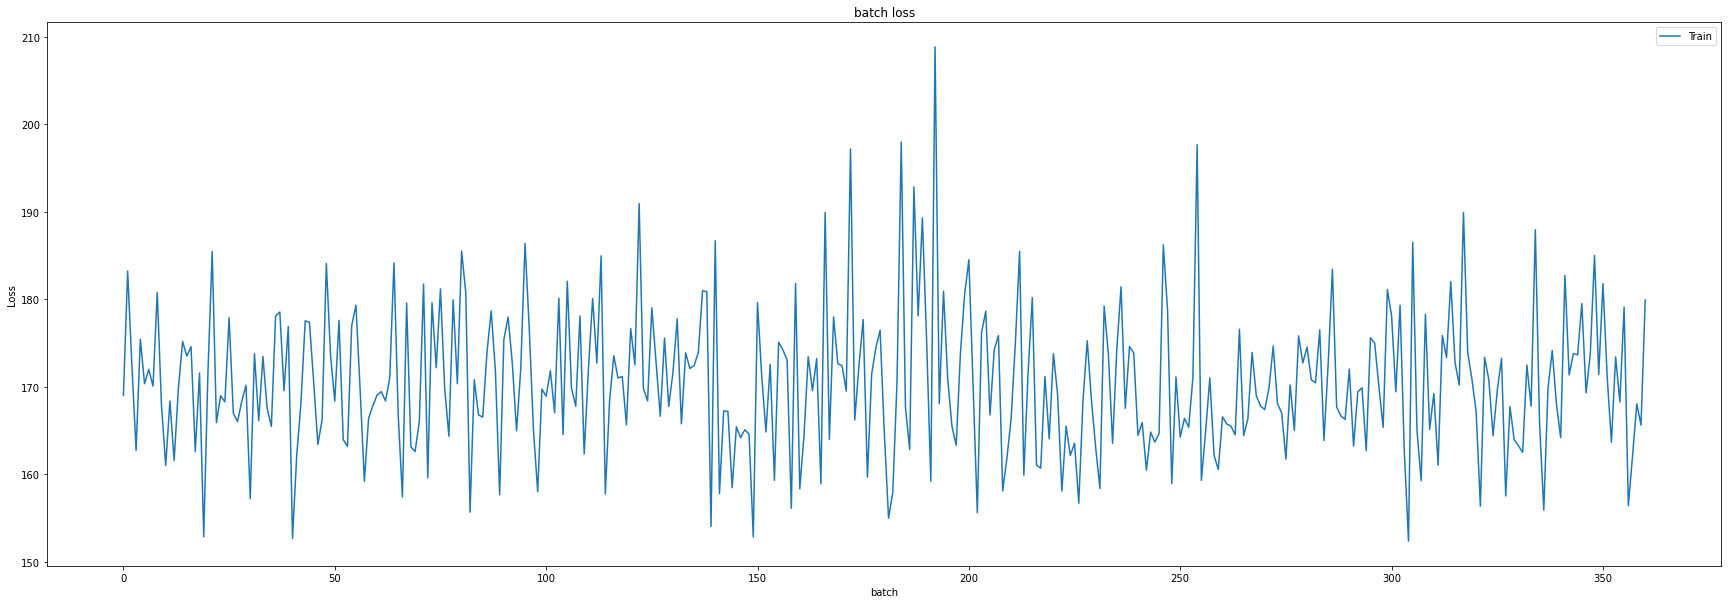

In [37]:
visualizer = Visualizer()
visualizer.loss_plot(feature_loss)
visualizer.save_figure(r'pic/test/'+"debug_tag{}_".format(str(param["debug_tag"]))+'feature_loss.png')
visualizer = Visualizer()
visualizer.loss_plot(ab_loss)
visualizer.save_figure(r'pic/test/'+"debug_tag{}_".format(str(param["debug_tag"]))+'ab_loss.png')
visualizer = Visualizer()
visualizer.loss_plot(normal_loss)
visualizer.save_figure(r'pic/test/'+"debug_tag{}_".format(str(param["debug_tag"]))+'normal_loss.png')
print(len(normal_loss))

In [71]:
# # 目前想法把train_feature,ab_feature,normal_feature同时降维观察
# import numpy as numpy
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# def plot_embedding(data, label, title):
#     x_min, x_max = numpy.min(data, 0), numpy.max(data, 0)
#     data = (data - x_min) / (x_max - x_min)
#     colors = {0:'r',1:'b'}
#     fig = plt.figure()
#     ax = plt.subplot(111)
#     for i in range(data.shape[0]):
#         plt.text(data[i, 0], data[i, 1], '.',
#                  color=colors[int(label[i])],
#                  fontdict={'weight': 'bold', 'size': 9})
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(title)
#     return fig

# tsne = TSNE(n_components=2, init='pca', random_state=0)




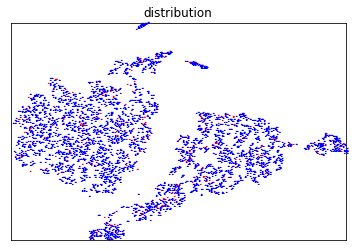

In [73]:
#部分降维
# zero = torch.zeros(len(ab_feature))
# one = torch.ones(len(normal_feature))
# label = torch.cat((zero,one),0)
# feature = ab_feature + normal_feature
# print(len(feature))
# print(len(label))
# result = tsne.fit_transform(feature[:5000])
# fig = plot_embedding(result[:5000], label[:5000],'distribution')
# plt.show(fig)

In [74]:
# result = tsne.fit_transform(feature)

In [75]:
# fig = plot_embedding(result, label,'distribution')
# plt.savefig('distribution_all.png')
# plt.show(fig)

IndexError: index 5856 is out of bounds for dimension 0 with size 5856

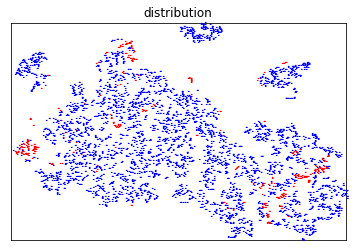

In [ ]:
# fig = plot_embedding(result[:5000], label[:5000],'distribution')
# plt.savefig('distribution_all_5000.png')
# plt.show(fig)

In [38]:
def cosine_distance(matrix1,matrix2):
    matrix1_matrix2 = numpy.dot(matrix1, matrix2.transpose())
    matrix1_norm = numpy.sqrt(numpy.multiply(matrix1, matrix1).sum(axis=1))
    matrix1_norm = matrix1_norm[:, numpy.newaxis]
    matrix2_norm = numpy.sqrt(numpy.multiply(matrix2, matrix2).sum(axis=1))
    matrix2_norm = matrix2_norm[:, numpy.newaxis]
    cosine_distance = numpy.divide(matrix1_matrix2, numpy.dot(matrix1_norm, matrix2_norm.transpose()))
    return cosine_distance

tensor([-0.1216, -1.2831, -0.9816,  0.3606,  0.6270, -0.6958,  0.3331, -0.4137,
         0.0645, -0.9434, -0.1268,  1.4948, -0.5139,  0.7323,  0.0945,  0.6523,
        -0.0731,  0.2800,  0.2242,  2.0184,  0.3315,  0.0579,  0.7393, -0.2644,
         1.1502, -0.3005,  0.8940, -0.7258,  0.7249,  0.9611,  0.6358, -1.0289])

In [50]:
feature = torch.Tensor(feature).numpy()
ab_feature = torch.Tensor(ab_feature).numpy()
normal_feature = torch.Tensor(normal_feature).numpy()
ab_distance = cosine_distance(ab_feature,feature)
normal_distance = cosine_distance(normal_feature,feature)

In [51]:
print(feature.shape)
print(normal_feature.shape)
print(ab_feature.shape)

print(ab_distance.shape)
print(normal_distance.shape)

(115400, 32)
(11540, 32)
(2308, 32)
(2308, 115400)
(11540, 115400)


In [52]:
print(ab_distance.argmax(axis=1))
print(normal_distance.argmax(axis=1))

[ 64772 101773  13123 ...  88354  13478  43738]
[104971  23564  48042 ...  65916  65671  62920]


In [53]:
part_feature = numpy.array(feature[:100],dtype='float64')
part_ab_feature = numpy.array(ab_feature[:100],dtype='float64')
part_normal_feature = numpy.array(normal_feature[:100],dtype='float64')
part_ab_distance = cosine_distance(part_ab_feature,numpy.array(part_feature,dtype='float64'))
part_normal_distance = cosine_distance(part_normal_feature,numpy.array(part_feature,dtype='float64'))



In [21]:
numpy.save('distance/cos/ab_data',ab_distance.max(axis=1))
numpy.save('distance/cos/normal_data',normal_distance.max(axis=1))

In [54]:
print(ab_distance.max(axis=1))
print(normal_distance.max(axis=1))

[0.9880232  0.979564   0.9722623  ... 0.997387   0.9902967  0.99110484]
[0.9852252  0.991201   0.9620497  ... 0.97956884 0.9793403  0.9828672 ]


In [55]:
print(ab_distance.max(axis=1).mean())
print(normal_distance.max(axis=1).mean())

0.9864963
0.97754455


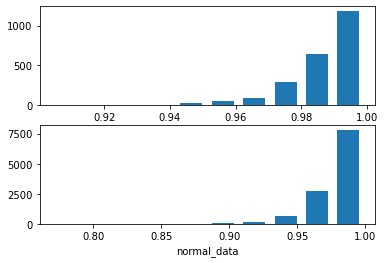

In [56]:
import matplotlib.pylab as plt 
plt.subplot(211)
plt.hist(ab_distance.max(axis=1),rwidth=0.7)
plt.xlabel("abdata")
plt.subplot(212)
plt.hist(normal_distance.max(axis=1),rwidth=0.7)
plt.xlabel("normal_data")
plt.show()